In [1]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import numba
from scipy.optimize import curve_fit


In [2]:
def read_wave(file_path):
    with wave.open(file_path, 'r') as wf:
        # Extract audio data
        n_frames = wf.getnframes()
        n_channels = wf.getnchannels()
        sample_width = wf.getsampwidth()
        sample_rate = wf.getframerate()

        

        # Read frames and convert to numpy array
        frames = wf.readframes(n_frames)
        signal = np.frombuffer(frames, dtype=np.int32)  # Assuming 32-bit WAV files
        signal = signal/np.max(np.abs(signal))
        signal = abs(signal)

        # If stereo, take only one channel
        if n_channels > 1:
            signal = signal[::n_channels]

        # Create time array
        time = np.linspace(0, n_frames / sample_rate, num=len(signal))
        

    return signal, sample_rate, time

@numba.njit(fastmath=True)
def peak_finder_neigh(t_list, y_list, neigh=2, threshold=0.1):
    t_peak = []
    peaks = []
    for i in range(len(y_list) - neigh):
        if y_list[i] > y_list[i-1] and y_list[i] > y_list[i+1] and y_list[i] > threshold:

            # check N neighbours each way
            index_check = []
            for j in range(1, neigh+1):
                if y_list[i] > y_list[i-j] and y_list[i] > y_list[i+j]:
                    index_check.append(True)
                else:
                    index_check.append(False)

            if sum(index_check) == neigh:
                peaks.append(y_list[i])
                t_peak.append(t_list[i])

    return np.array(t_peak), np.array(peaks)

@numba.njit(fastmath=True)
def signal_avg(signal, time, step):
    new_signal = []
    new_time = time[::step] 

    i = 0
    while i < len(signal):
        if i+10 < len(signal):
            new_signal.append(np.mean(signal[i:i+step]))
            i += step
        else:
            new_signal.append(np.mean(signal[i:]))
            i += step

    return new_time, new_signal

@numba.njit(fastmath=True)
def lin_fit(x, a, b):
    return a*x + b

def data_extract(file, step=200, neigh=10, threshold=0.1):
    signal, sample_rate, time = read_wave(file)
    time, signal = signal_avg(signal, time, step)
    peak_times, peaks = peak_finder_neigh(time, signal, neigh, threshold)

    freq_list = 1/np.diff(peak_times)
    freq_tlist = peak_times[:-1]

    fpar, fcov = curve_fit(lin_fit, freq_tlist, freq_list)

    return time, signal, peak_times, peaks, freq_tlist, freq_list, fpar, fcov



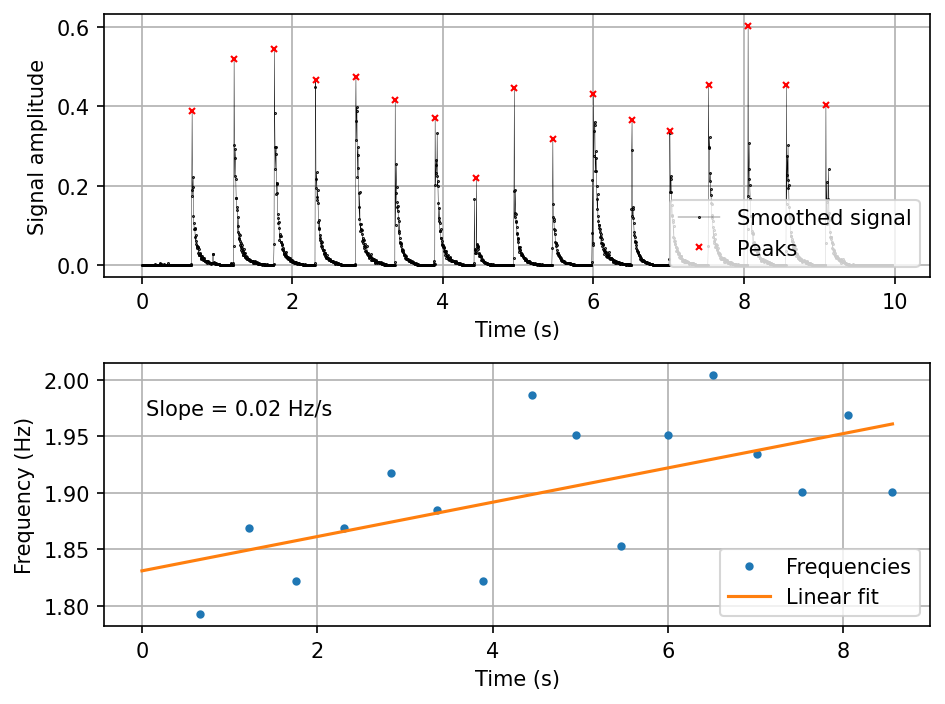

In [7]:
new_time, new_signal, peak_times, peaks, freq_tlist, freq_list, fpar, fcov = data_extract('trial.wav', step=200, neigh=10, threshold=0.1)

x_fit = np.linspace(0, max(freq_tlist), 1000)
y_fit = lin_fit(x_fit, *fpar)


fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(new_time, new_signal, color='black', ls='-', marker='.', linewidth = 0.2, markersize=0.8, label='Smoothed signal')
ax[0].plot(peak_times, peaks, color='red', ls='', marker='x', markersize=3, label='Peaks')
ax[0].grid()
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Signal amplitude')
ax[0].legend(loc='lower right')

ax[1].plot(freq_tlist, freq_list, '.', label='Frequencies')
ax[1].plot(x_fit, y_fit, label='Linear fit')
ax[1].grid()
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].text(0.05, 0.8, f'Slope = {fpar[0]:.2f} Hz/s', transform=ax[1].transAxes)
ax[1].legend(loc='lower right')

fig.tight_layout()